In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from matplotlib import pyplot as plt
from lifelines import CoxPHFitter
import numpy as np
import pandas as pd

## Testing the proportional hazard assumptions

This Jupyter notebook is a small tutorial on how to test and fix proportional hazard problems. 

The proportional hazard assumption is that _all_ individuals have the same hazard function, but a unique scaling factor infront. So the _shape_ of the hazard function is the same for all individuals, and only a scalar infront changes. 

$$h_i(t) = a_i h(t)$$

At the core of the  assumption is that $a_i$ is not time varying, that is, $a_i(t) = a_i$.. In this tutorial we will test this non-time varying assumption, and look at ways to handle violations. 


In [38]:
from lifelines.datasets import load_rossi
rossi = load_rossi()
cph = CoxPHFitter()

cph.fit(rossi, 'week', 'arrest')

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

In [39]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
number of subjects = 432
  number of events = 114
    log-likelihood = -658.748
  time fit was run = 2019-02-19 17:35:13 UTC
             model = untransformed variables


---
       coef  exp(coef)  se(coef)      z     p  -log2(p)  lower 0.95  upper 0.95
fin  -0.379      0.684     0.191 -1.983 0.047     4.398      -0.755      -0.004
age  -0.057      0.944     0.022 -2.611 0.009     6.791      -0.101      -0.014
race  0.314      1.369     0.308  1.019 0.308     1.698      -0.290       0.918
wexp -0.150      0.861     0.212 -0.706 0.480     1.058      -0.566       0.266
mar  -0.434      0.648     0.382 -1.136 0.256     1.965      -1.182       0.315
paro -0.085      0.919     0.196 -0.434 0.665     0.589      -0.469       0.299
prio  0.091      1.096     0.029  3.194 0.001     9.476       0.035       0.148
---
Concordance = 0.640
Log-likelihood ratio test = 33.266

### Checking assumptions with `check_assumptions`

New to lifelines 0.16.0 is the `CoxPHFitter.check_assumptions` method. This method will compute statistics that check the proportional hazard assumption, produce plots to check assumptions, and more. Also included is an option to display advice to the console. Here's a breakdown of each information displayed:

 - Presented first are the results of a statistical test to test for any time-varying coefficients. A time-varying coefficient imply a covariate's influence _relative to the baseline_ changes over time. This implies a violation of the proportional hazard assumption. For each variable, we transform _time_ four times (these are common transformations of time to perform). If _lifelines_ rejects the null (that is, _lifelines_ rejects that the coefficient is not time-varying), we report this to the user.
 - Some advice is presented on how to correct the proportional hazard violation based on some summary statistics of the variable. 
 - As a compliment to the above statistical test, for each variable that violates the PH assumption, visual plots of the the _scaled Schoenfeld residuals_ is presented against the four time transformations. A fitted lowess is also presented, along with 10 bootstrapped lowess lines (as an approximation to the confidence interval of the original lowess line). Ideally, this lowess line is constant (flat). Deviations away from the constant line are violations of the PH assumption. 
 
####  Why the _scaled Schoenfeld residuals_?
 
This section can be skipped on first read. Let $s_{t,j}$ denote the scaled Schoenfeld residuals of variable $j$ at time $t$, $\hat{\beta_j}$ denote the maximum-likelihood estimate of the $j$th variable, and $\beta_j(t)$ a time-varying coefficient in (fictional) alternative model that allows for time-varying coefficients. Therneau and Grambsch showed that. 

$$E[s_{t,j}] + \hat{\beta_j} = \beta_j(t)$$

The proportional hazard assumption implies that $\hat{\beta_j} = \beta_j(t)$, hence $E[s_{t,j}] = 0$. This is what the above proportional hazard test is testing. Visually, plotting $s_{t,j}$ over time (or some transform of time), is a good way to see violations of $E[s_{t,j}] = 0$, along with the statisical test. 

In [4]:
cph.check_assumptions(rossi)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some covariates
will be below the threshold (i.e. by chance). This is compounded when there are many covariates.

Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and eyeball tests to
determine the most serious violations.


<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
           test_statistic      p  -log2(p)
age  km             11.03 <0.005     10.12
     rank           11.09 <0.005     10.17
fin  km              0.02   0.89      0.17
     rank            0.02   0.90      0.16
mar  km              0.60   0.44      1.19
     rank            0.67   0.41      1.27
paro km              0.12   0.73      0.45
     rank            0.14   0.71      0.49
prio km   

Alternatively, you can use the proportional hazard test outside of `check_assumptions`:

In [5]:
from lifelines.statistics import proportional_hazard_test

results = proportional_hazard_test(cph, rossi, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
      test_statistic     p  -log2(p)
age           11.094 0.001    10.173
fin            0.017 0.896     0.158
mar            0.666 0.414     1.271
paro           0.138 0.711     0.493
prio           0.023 0.881     0.183
race           1.462 0.227     2.141
wexp           7.180 0.007     7.084


In the advice above, we can see that `wexp` has small cardinality, so we can easily fix that by specifying it in the `strata`. What does the `strata` do? Let's go back to the proportional hazard assumption.

In the introduction, we said that the proportional hazard assumption was that 

$$ h_i(t) = a_i h(t)$$

In a simple case, it may be that there are two subgroups that have _very_ different baseline hazards. That is, we can split the dataset into subsamples based on some variable (we call this the stratifying variable), run the Cox model on all subsamples, and compare their baseline hazards. If these baseline hazards are _very_ different, then clearly the formula above is wrong - the $h(t)$ is some weighted average of the subgroups' baseline hazards. This ill fitting average baseline can cause $a_i$ to have time-dependent influence. A better model might be:

$$ h_{i |i\in G}(t) = a_i h_G(t)$$

where now we have a unique baseline hazard _per_ subgroup $G$. Because of the way the Cox model is designed, inference of the coefficients is identical (expect now there are more baseline hazards, and no variation of the stratifying variable within a subgroup $G$). 


In [6]:
cph.fit(rossi, 'week', 'arrest', strata=['wexp'])
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
            strata = ['wexp']
number of subjects = 432
  number of events = 114
    log-likelihood = -580.89
  time fit was run = 2019-02-19 17:30:49 UTC

---
      coef  exp(coef)  se(coef)     z      p  -log2(p)  lower 0.99  upper 0.99
fin  -0.38       0.68      0.19 -1.99   0.05      4.42       -0.87        0.11
age  -0.06       0.94      0.02 -2.64   0.01      6.91       -0.12       -0.00
race  0.31       1.36      0.31  1.00   0.32      1.65       -0.49        1.10
mar  -0.45       0.64      0.38 -1.19   0.23      2.09       -1.44        0.53
paro -0.08       0.92      0.20 -0.42   0.67      0.57       -0.59        0.42
prio  0.09       1.09      0.03  3.16 <0.005      9.33        0.02        0.16
---
Concordance = 0.61
Log-likelihood ratio test = 188.99 on 6 df, -log2(p)=124.17


In [7]:
cph.check_assumptions(rossi)


The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some covariates
will be below the threshold (i.e. by chance). This is compounded when there are many covariates.

Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and eyeball tests to
determine the most serious violations.


<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
 null_distribution = chi squared
degrees_of_freedom = 1

---
           test_statistic      p  -log2(p)
age  km             11.29 <0.005     10.32
     rank            4.62   0.03      4.99
fin  km              0.02   0.90      0.16
     rank            0.05   0.83      0.28
mar  km              0.53   0.47      1.10
     rank            1.31   0.25      1.99
paro km              0.09   0.76      0.40
     rank            0.00   0.97      0.05
prio km   

Since `age` is still violating the proportional hazard assumption, we need to model it better.  From the residual plots above, we can see a the effect of age start to become negative over time. This will be relevant later. Below, we present two options to handle `age`. 

#### Option 1: bin variable and stratify on it


The first option proposed is to bin the variable into equal-sized bins, and stratify like we did with `wexp`. There is a trade off here between estimation and information-loss. If we have large bins, we will lose information (since different values are now binned together), but we need to estimate less new baseline hazards. On the other hand, with tiny bins, we allow the `age` data to have the most "wiggle room", but must compute many baseline hazards each of which has a smaller sample size. Like most things, the optimial value is somewhere inbetween.

In [8]:
rossi_strata_age = rossi.copy()
rossi_strata_age['age_strata'] = pd.cut(rossi_strata_age['age'], np.arange(0, 80, 3))

rossi_strata_age[['age', 'age_strata']].head()

,age,age_strata
0,27,"(24, 27]"
1,18,"(15, 18]"
2,19,"(18, 21]"
3,23,"(21, 24]"
4,19,"(18, 21]"


In [9]:
# drop the orignal, redundant, age column
rossi_strata_age = rossi_strata_age.drop('age', axis=1)
cph.fit(rossi_strata_age, 'week', 'arrest', strata=['age_strata', 'wexp'])

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>

<lifelines.CoxPHFitter: fitted with 432 observations, 318 censored>
      duration col = 'week'
         event col = 'arrest'
            strata = ['age_strata', 'wexp']
number of subjects = 432
  number of events = 114
    log-likelihood = -392.443
  time fit was run = 2019-02-19 17:30:49 UTC
             model = stratified age and wexp


---
       coef  exp(coef)  se(coef)      z     p  -log2(p)  lower 0.99  upper 0.99
fin  -0.395      0.674     0.197 -2.004 0.045     4.472      -0.903       0.113
race  0.280      1.324     0.313  0.895 0.371     1.431      -0.527       1.088
mar  -0.194      0.824     0.392 -0.494 0.621     0.687      -1.202       0.815
paro -0.163      0.849     0.200 -0.818 0.413     1.275      -0.678       0.351
prio  0.080      1.084     0.028  2.854 0.004     7.857       0.008       0.153
---
Concordance = 0.582
Log-likelihood ratio test = 565.874 on 5 df, -log2(p)=396.379


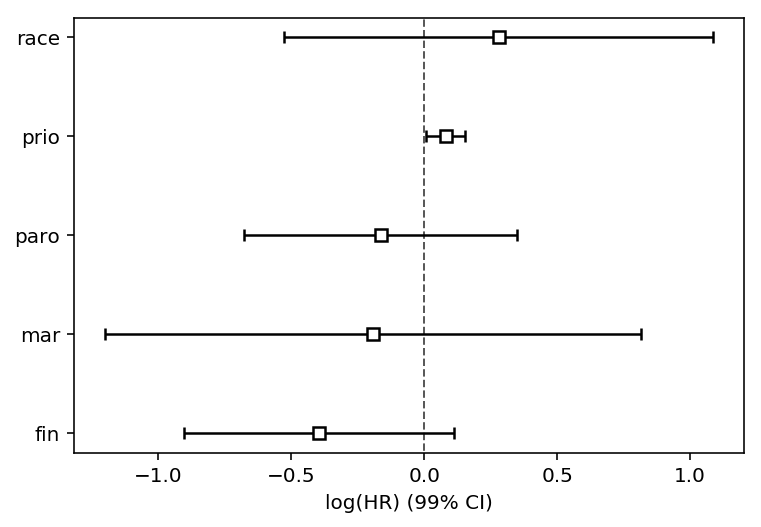

In [10]:
cph.print_summary(3, model="stratified age and wexp")
cph.plot()

In [11]:
cph.check_assumptions(rossi_strata_age)

Proportional hazard assumption looks okay.


#### Option 2: introduce time-varying covariates

Our second option to correct variables that violate the proportional hazard assumption is to model the time-varying component directly. This is done in two steps. The first is to transform your dataset into _episodic format_. This means that we split a subject from a single row into $n$ new rows, and each new row represents some time period for the subject. It's okay that the variables are static over this new time periods - we'll introduce some time-varying covariates later.

See below for how to do this in _lifelines_:

In [12]:
from lifelines.utils import to_episodic_format

# the time_gaps parameter specifies how large or small you want the periods to be. 
rossi_long = to_episodic_format(rossi, duration_col='week', event_col='arrest', time_gaps=1.)
rossi_long.head(25)


,stop,start,arrest,age,fin,id,mar,paro,prio,race,wexp
0,1.0,0.0,0,27,0,0,0,1,3,1,0
1,2.0,1.0,0,27,0,0,0,1,3,1,0
2,3.0,2.0,0,27,0,0,0,1,3,1,0
3,4.0,3.0,0,27,0,0,0,1,3,1,0
4,5.0,4.0,0,27,0,0,0,1,3,1,0
5,6.0,5.0,0,27,0,0,0,1,3,1,0
6,7.0,6.0,0,27,0,0,0,1,3,1,0
7,8.0,7.0,0,27,0,0,0,1,3,1,0
8,9.0,8.0,0,27,0,0,0,1,3,1,0
9,10.0,9.0,0,27,0,0,0,1,3,1,0


Each subject is given a new id (but can be specified as well if already provided in the dataframe). This id is used to track subjects over time. Notice the `arrest` col is 0 for all periods prior to their (possible) event as well. 

Above I mentioned there were two steps to correct `age`. The first was to convert to a episodic format. The second is to create an interaction term between `age` and `stop`. This is a time-varying variable.

Instead of `CoxPHFitter`, we must use `CoxTimeVaryingFitter` instead since we are working with a episodic dataset. 

In [13]:
rossi_long['time*age'] = rossi_long['age'] * rossi_long['stop']

In [14]:
from lifelines import CoxTimeVaryingFitter
ctv = CoxTimeVaryingFitter()

ctv.fit(rossi_long, 
        id_col='id', 
        event_col='arrest', 
        start_col='start', 
        stop_col='stop', 
        strata=['wexp'])

<lifelines.CoxTimeVaryingFitter: fitted with 19809 periods, 432 subjects, 114 events>

In [15]:
ctv.print_summary(3)

<lifelines.CoxTimeVaryingFitter: fitted with 19809 periods, 432 subjects, 114 events>
         event col = 'arrest'
            strata = ['wexp']
number of subjects = 432
 number of periods = 19809
  number of events = 114
    log-likelihood = -575.080
  time fit was run = 2019-02-19 17:30:53 UTC

---
           coef  exp(coef)  se(coef)      z     p  -log2(p)  lower 0.95  upper 0.95
age       0.073      1.075     0.040  1.830 0.067     3.893      -0.005       0.151
fin      -0.386      0.680     0.191 -2.018 0.044     4.520      -0.760      -0.011
mar      -0.397      0.672     0.382 -1.039 0.299     1.743      -1.147       0.352
paro     -0.098      0.907     0.196 -0.501 0.616     0.698      -0.481       0.285
prio      0.090      1.094     0.029  3.152 0.002     9.267       0.034       0.146
race      0.295      1.343     0.308  0.955 0.340     1.558      -0.310       0.899
time*age -0.005      0.995     0.002 -3.337 0.001    10.203      -0.008      -0.002
---
Log-likelihood ratio 

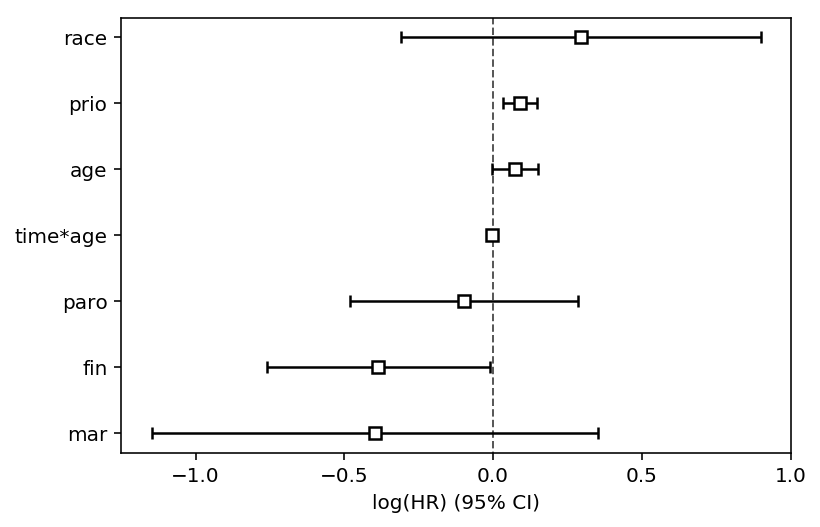

In [16]:
ctv.plot()

In the above scaled Schoenfeld residual plots for `age`, we can see there is a slight negative effect for higher time values. This is confirmed in the output of the `CoxTimeVaryingFitter`: we see that the coefficient for `time*age` is -0.005.

#### Conclusion

The point estimates and the standard errors are very close to each other using either option, we can feel confident that either approach is okay to proceed. 